In [1]:
################################################################################
#######################    Time series decomposition    ########################
################################################################################
# For more information, check https://www.machinelearningplus.com/time-series/time-series-analysis-python/ 
### Load necessary modules -------------------------------
from dateutil.parser import parse 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import math
plt.style.use('ggplot')
plt.rcParams.update({'figure.figsize': (10, 7), 'figure.dpi': 120})
import numpy as np
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
import ForecastingTools as FT
import seaborn as sns
import scipy.stats as st
from statsmodels.tsa.stattools import adfuller

In [2]:
# Import data
df = pd.read_excel('ARIMA_II.xls')
df.head()

Y1        Y2        Y3     Y4        Y5
0 -0.587047  0.993847  0.983347  0.987  1.022369
1 -1.427480  0.985104  0.950711  0.969  1.071212
2  0.059141  1.000622  0.932761  0.958  1.140348
3  0.653344  1.006893  0.940219  0.999  1.228530
4 -1.788129  0.981376  0.941066  0.952  1.337822

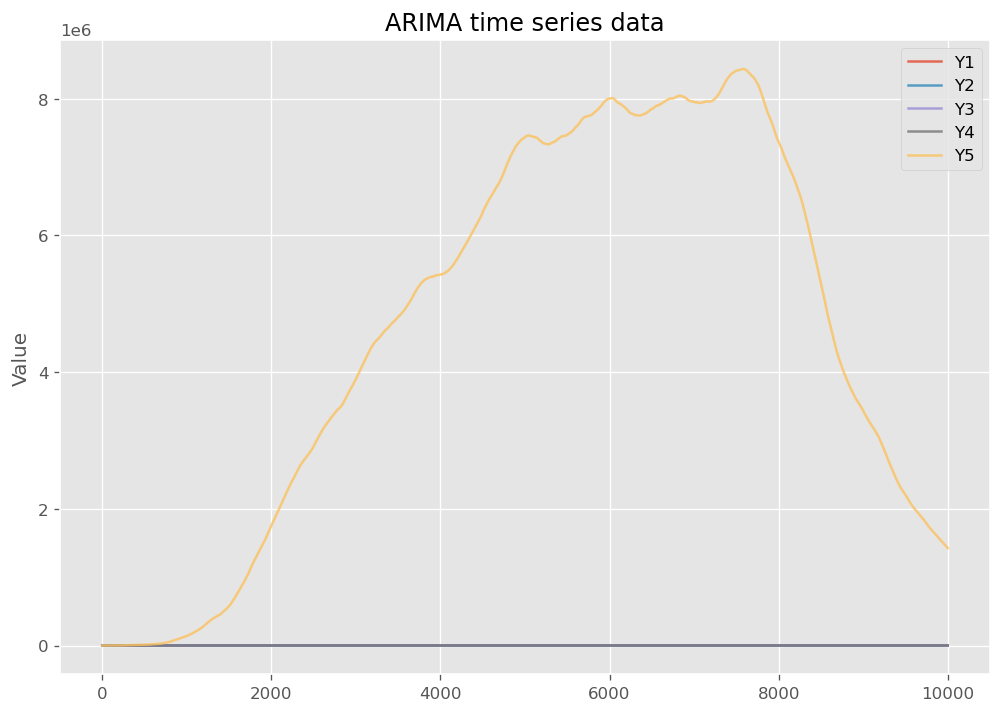

In [3]:
# Plotting a time series
fig, ax = plt.subplots()
for col in df.columns.values.tolist():
    ax.plot(col, data=df, label=col, alpha=0.8)
ax.set(title='ARIMA time series data', ylabel='Value')
plt.legend()
plt.show()

In [4]:
df_ts = df[['Y1']] # Maintain data.frame format for column
df_ts

Y1
0     -0.587047
1     -1.427480
2      0.059141
3      0.653344
4     -1.788129
...         ...
9995  53.313085
9996  52.638512
9997  52.023497
9998  51.629786
9999  52.230324

[10000 rows x 1 columns]

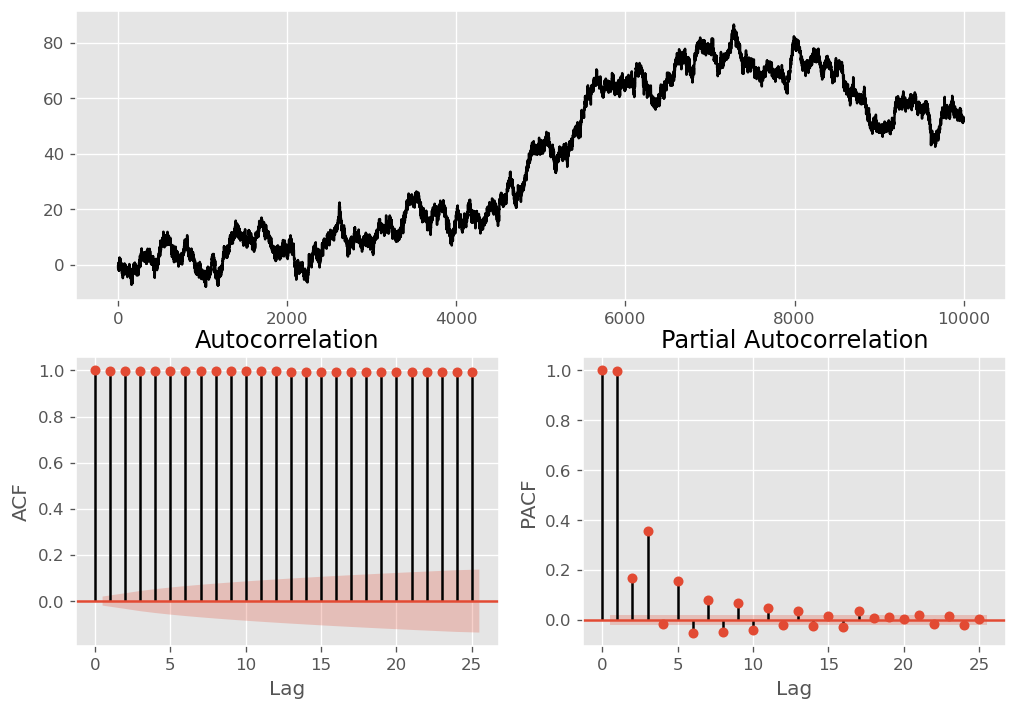

In [5]:
## Identification frocess 
# ACF and PACF of the time series -> identify significant lags and order
FT.ts_display(df_ts)

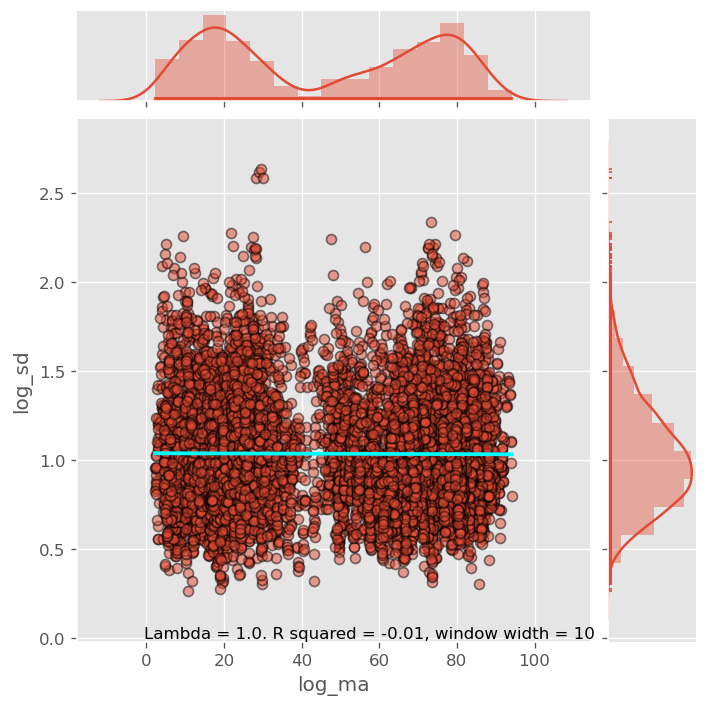

In [6]:
# Box-Cox transformation
FT.boxcox_lambda_plot(df_ts, window_width=10)

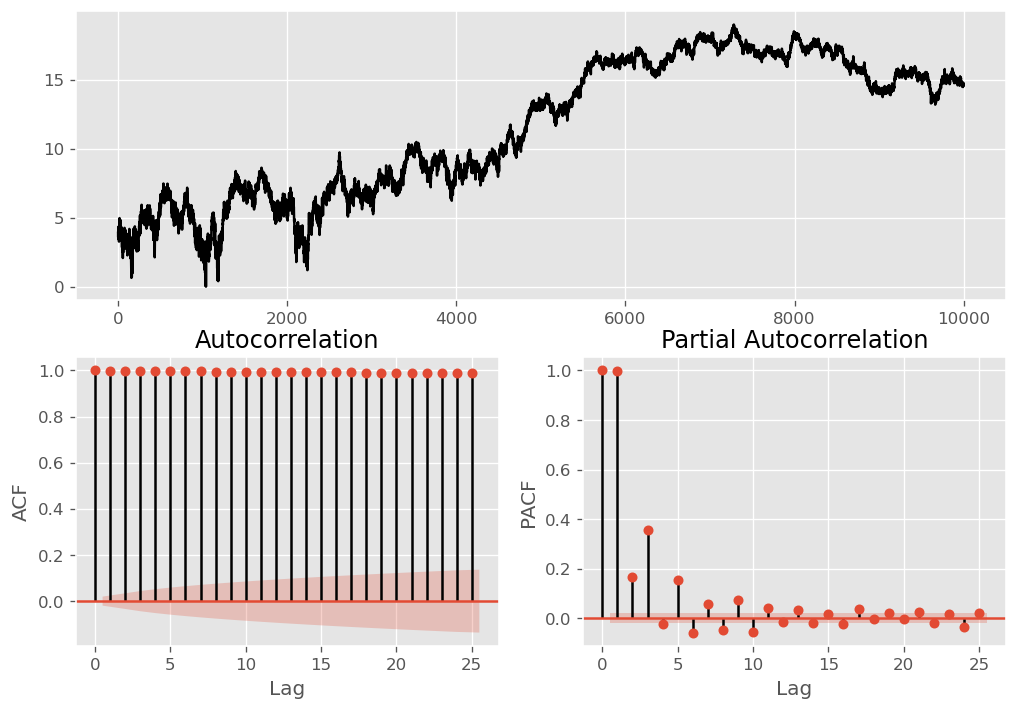

In [7]:
# Plot transformed data
z, _ = st.boxcox(df_ts.values[:,0] - min(df_ts.values) + 1)
z = pd.DataFrame(z, columns=df_ts.columns.values.tolist())
FT.ts_display(z)

In [8]:
# Alternative test - Augmented Dickey Fuller Test
result = adfuller(z.values)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.478959
p-value: 0.543893
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


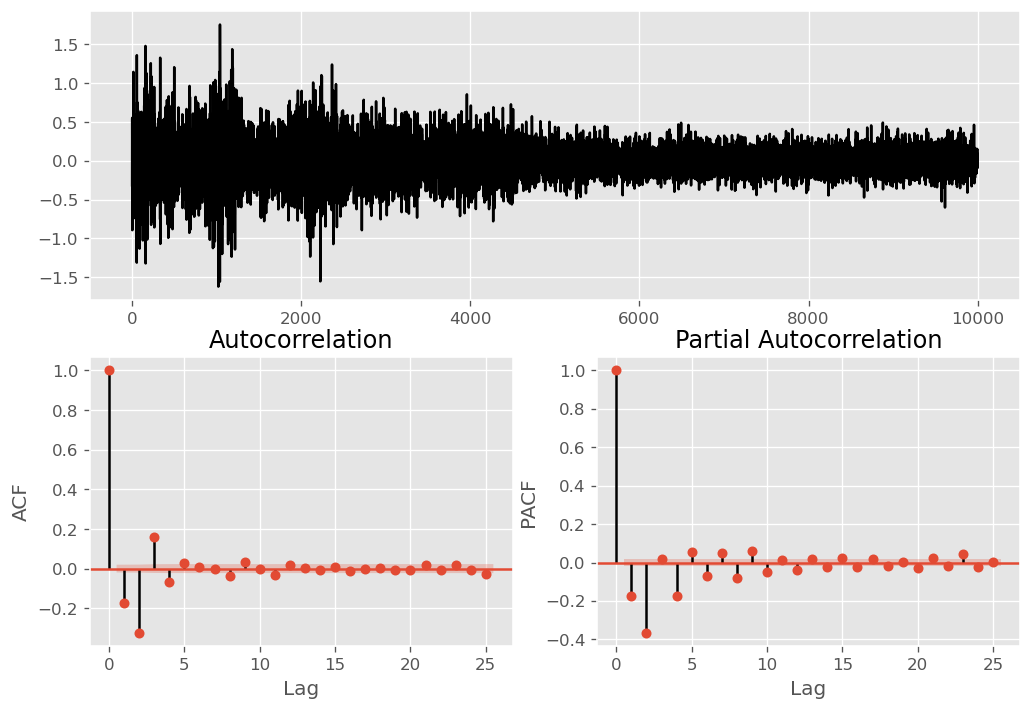

In [9]:
# Difference of the time series
Bz = z.diff().loc[1:] # drop first NA value
FT.ts_display(Bz)

In [10]:
# Fit model with estimated order
# If you want to apply Boxcox
boxcox = False
p = 1
d = 1
q = 2
if boxcox:
    arima_fit = ARIMA(z, order=(p,d,q)).fit(disp=0)
else:
    arima_fit = ARIMA(df_ts, order=(p,d,q)).fit(disp=0)

print(arima_fit.summary())

ARIMA Model Results                              
Dep. Variable:                   D.Y1   No. Observations:                 9999
Model:                 ARIMA(1, 1, 2)   Log Likelihood              -14192.236
Method:                       css-mle   S.D. of innovations              1.000
Date:                Mon, 24 Aug 2020   AIC                          28394.472
Time:                        17:52:32   BIC                          28430.523
Sample:                             1   HQIC                         28406.675
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0053      0.005      0.977      0.329      -0.005       0.016
ar.L1.D.Y1    -0.4826      0.016    -29.279      0.000      -0.515      -0.450
ma.L1.D.Y1     0.2931      0.015     19.524      0.000       0.264       0.323
ma

Ljung-Box test of residuals:
      lb_stat  lb_pvalue
25  18.597629   0.815994


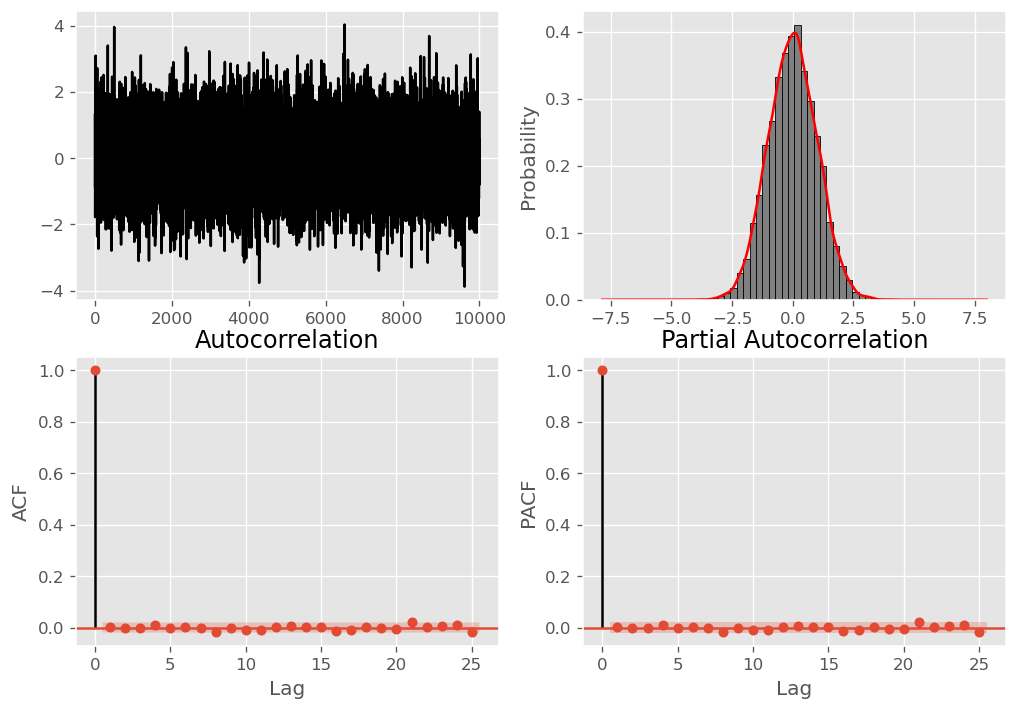

In [11]:
# Plot residual error
FT.check_residuals(pd.DataFrame(arima_fit.resid))

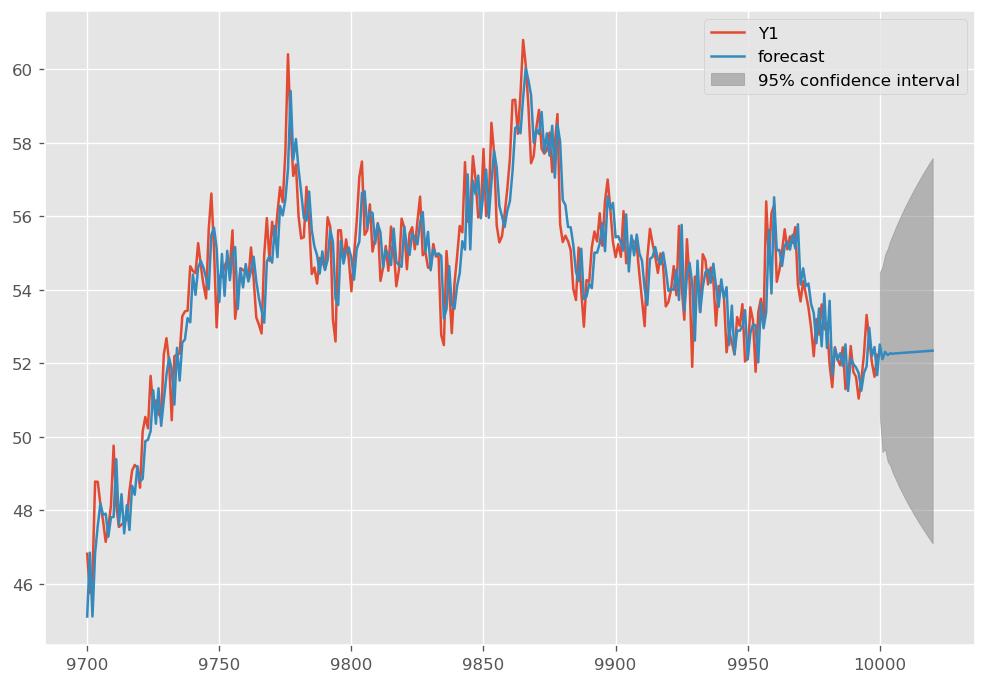

In [50]:
# Plot prediction and confidence intervals
# If using dynamic = True, the forecast are used as real data 
horizon = 20
fig, ax = plt.subplots()
ax = df_ts.loc[9700:].plot(ax=ax)
fig = arima_fit.plot_predict(9700, df_ts.shape[0] + horizon, 
                        dynamic=False, ax=ax,
                        plot_insample=False)
plt.show()